In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
    #for filename in filenames:
        #print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import os
from imblearn.over_sampling import RandomOverSampler
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import seaborn as sns
from sklearn.preprocessing import label_binarize

2024-06-12 00:44:27.485343: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-12 00:44:27.485491: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-12 00:44:27.620738: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
covid_path = "/kaggle/input/covid19-with-out-ling-mask/CovidXRayImages/Val/COVID-19"
print("covid file len: ", len(os.listdir(covid_path)))

Non_covid_path = "/kaggle/input/covid19-with-out-ling-mask/CovidXRayImages/Val/Non-COVID"
print("Non covid file len: ", len(os.listdir(Non_covid_path)))

Normal_path = "/kaggle/input/covid19-with-out-ling-mask/CovidXRayImages/Val/Normal"
print("Normal file len: ", len(os.listdir(Normal_path)))

covid file len:  1903
Non covid file len:  1802
Normal file len:  1712


In [4]:

X = []
y = []


def populate_image_list(class_path,class_label):
    image_list = os.listdir(class_path)
    for img_name in image_list:
        X.append(os.path.join(class_path,img_name))
        y.append(class_label)
        
populate_image_list(covid_path,'COVID_19')
populate_image_list(Non_covid_path,'Non-COVID')
populate_image_list(Normal_path,'Normal')

In [5]:
'''
X = np.array(X).reshape(-1,1)
y = np.array(y)
'''

'\nX = np.array(X).reshape(-1,1)\ny = np.array(y)\n'

Applying OverSampler

In [6]:
'''ros = RandomOverSampler(random_state=42)
X_over_resampled, y_over_resampled = ros.fit_resample(X,y)

#Convert back to list
X_over_resampled = X_over_resampled.flatten().tolist()
y_over_resampled = y_over_resampled.tolist()
'''

'ros = RandomOverSampler(random_state=42)\nX_over_resampled, y_over_resampled = ros.fit_resample(X,y)\n\n#Convert back to list\nX_over_resampled = X_over_resampled.flatten().tolist()\ny_over_resampled = y_over_resampled.tolist()\n'

In [7]:
#len(X_over_resampled)

In [8]:
# Define image size and batch size
img_size = (256, 256)
batch_size = 32
# Create data generators
img_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    validation_split=0.2,
    fill_mode='nearest'
)

#test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = img_datagen.flow_from_directory(
    '/kaggle/input/covid19-with-out-ling-mask/CovidXRayImages/Val',
    target_size=img_size,
    batch_size=batch_size,
    color_mode = 'grayscale',
    class_mode='categorical',
    subset='training',
    shuffle=True
)

test_generator = img_datagen.flow_from_directory(
    '/kaggle/input/covid19-with-out-ling-mask/CovidXRayImages/Val/',
    target_size=img_size,
    batch_size=batch_size,
    color_mode = 'grayscale',
    class_mode='categorical',
    subset='validation',
    shuffle=True
)

Found 4335 images belonging to 3 classes.
Found 1082 images belonging to 3 classes.


In [9]:
# Define the model
def create_model(input_shape):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu',padding='same', input_shape=input_shape,kernel_regularizer='l2'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        
        Conv2D(64, (3, 3), activation='relu',padding='same',kernel_regularizer='l2'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        
        Conv2D(128, (3, 3), activation='relu',padding='same',kernel_regularizer='l2'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        
        Conv2D(256, (3, 3), activation='relu',padding='same',kernel_regularizer='l2'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        
        Conv2D(256, (3, 3), activation='relu',padding='same',kernel_regularizer='l2'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        
        Flatten(),
        Dense(512, activation='relu',kernel_regularizer='l2'),
        #BatchNormalization(),
        Dropout(0.5),
        Dense(256, activation='relu',kernel_regularizer='l2'),
        #BatchNormalization(),
        Dropout(0.5),
        Dense(3, activation='softmax')  # Assuming 3 classes
    ])
    return model

In [10]:
# Create the model
input_shape = (img_size[0], img_size[1], 1)  # Update this as per your data
model = create_model(input_shape)
model.summary()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 256, 256, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256, 256, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 32, 32, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     8,389,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,502,083 (36.25 MB)

 Trainable params: 9,500,611 (36.24 MB)

 Non-trainable params: 1,472 (5.75 KB)

In [11]:
'''
# Compute class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights))
'''
from sklearn.utils import class_weight
classes = train_generator.classes

# Compute class weights
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(classes),
    y=classes
)

# Convert class weights to a dictionary
class_weights_dict = dict(enumerate(class_weights))

In [12]:
# Callbacks
def scheduler(epoch, lr):
    if epoch < 10:
        return float(lr)
    else:
        return float(lr * np.exp(-0.1))

In [13]:
from keras.callbacks import ReduceLROnPlateau
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_scheduler = LearningRateScheduler(scheduler)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)


In [14]:
# Training
history = model.fit(
   train_generator,
    epochs=50,
    validation_data=test_generator,
    class_weight=class_weights_dict,#class_weights,
    callbacks=[early_stopping,lr_scheduler]
)


Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  1/136 ━━━━━━━━━━━━━━━━━━━━ 1:03:29 28s/step - accuracy: 0.4062 - loss: 20.8645

I0000 00:00:1718153112.941383      87 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1718153112.965646      87 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


104/136 ━━━━━━━━━━━━━━━━━━━━ 15s 497ms/step - accuracy: 0.3827 - loss: 23.9231

W0000 00:00:1718153164.084230      87 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step - accuracy: 0.3833 - loss: 23.2243

W0000 00:00:1718153175.795520      84 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


136/136 ━━━━━━━━━━━━━━━━━━━━ 107s 580ms/step - accuracy: 0.3834 - loss: 23.2027 - val_accuracy: 0.3503 - val_loss: 14.0950 - learning_rate: 0.0010
Epoch 2/50


W0000 00:00:1718153191.208973      86 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


136/136 ━━━━━━━━━━━━━━━━━━━━ 38s 268ms/step - accuracy: 0.4062 - loss: 12.3772 - val_accuracy: 0.3512 - val_loss: 7.3509 - learning_rate: 0.0010
Epoch 3/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 38s 264ms/step - accuracy: 0.4015 - loss: 6.4444 - val_accuracy: 0.4372 - val_loss: 4.4994 - learning_rate: 0.0010
Epoch 4/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 38s 269ms/step - accuracy: 0.4151 - loss: 4.3362 - val_accuracy: 0.3595 - val_loss: 3.3999 - learning_rate: 0.0010
Epoch 5/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 39s 275ms/step - accuracy: 0.4222 - loss: 3.2384 - val_accuracy: 0.3993 - val_loss: 2.8811 - learning_rate: 0.0010
Epoch 6/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 38s 269ms/step - accuracy: 0.4472 - loss: 2.6455 - val_accuracy: 0.4982 - val_loss: 2.3830 - learning_rate: 0.0010
Epoch 7/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 38s 270ms/step - accuracy: 0.4731 - loss: 2.2938 - val_accuracy: 0.3327 - val_loss: 2.7124 - learning_rate: 0.0010
Epoch 8/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 39s 278ms/step - accuracy: 0.4717 - loss

In [15]:
# Evaluation
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
Y_true = test_generator.classes
print(classification_report(Y_true, y_pred_classes))


 1/34 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step

W0000 00:00:1718155165.085498      84 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


34/34 ━━━━━━━━━━━━━━━━━━━━ 9s 245ms/step
              precision    recall  f1-score   support

           0       0.39      0.34      0.36       380
           1       0.35      0.33      0.34       360
           2       0.31      0.37      0.34       342

    accuracy                           0.34      1082
   macro avg       0.35      0.34      0.34      1082
weighted avg       0.35      0.34      0.34      1082



W0000 00:00:1718155173.184554      85 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


In [16]:
train_loss, train_accuracy = model.evaluate(train_generator)
print("Overall training accuracy:",train_accuracy)
print("Overall trainig loss:",train_loss)

136/136 ━━━━━━━━━━━━━━━━━━━━ 34s 247ms/step - accuracy: 0.8778 - loss: 0.4634
Overall training accuracy: 0.8772779703140259
Overall trainig loss: 0.46128079295158386


W0000 00:00:1718155208.767561      87 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


In [17]:
loss, accuracy = model.evaluate(test_generator)
print(f'Test Accuracy: {accuracy*100:.2f}%')

34/34 ━━━━━━━━━━━━━━━━━━━━ 8s 237ms/step - accuracy: 0.8468 - loss: 0.5619
Test Accuracy: 84.10%


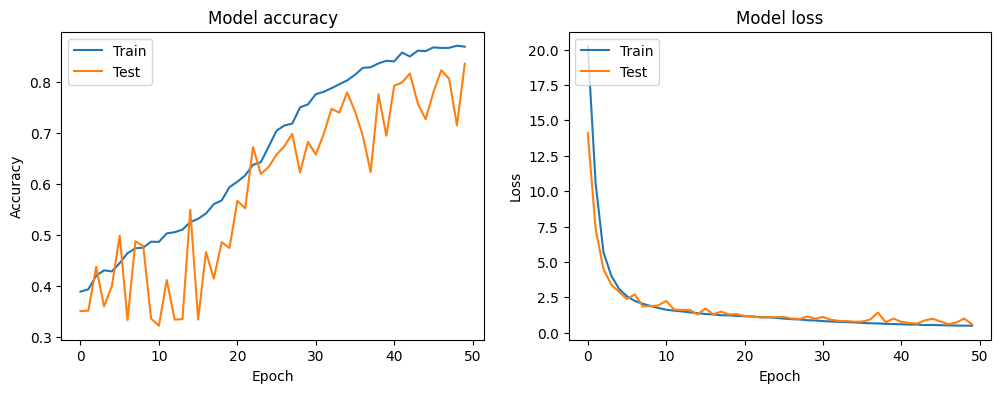

In [18]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.show()


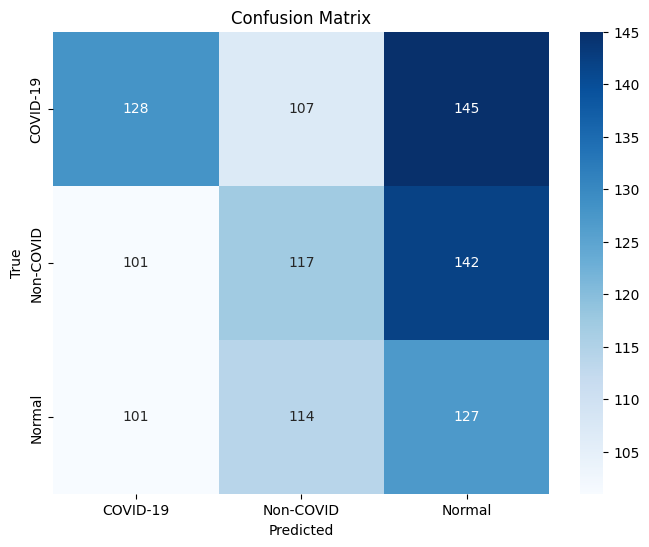

array([[128, 107, 145],
       [101, 117, 142],
       [101, 114, 127]])

In [19]:
# Compute confusion matrix
cm = confusion_matrix(Y_true, y_pred_classes)
cm_labels = list(test_generator.class_indices.keys())

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=cm_labels, yticklabels=cm_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
cm

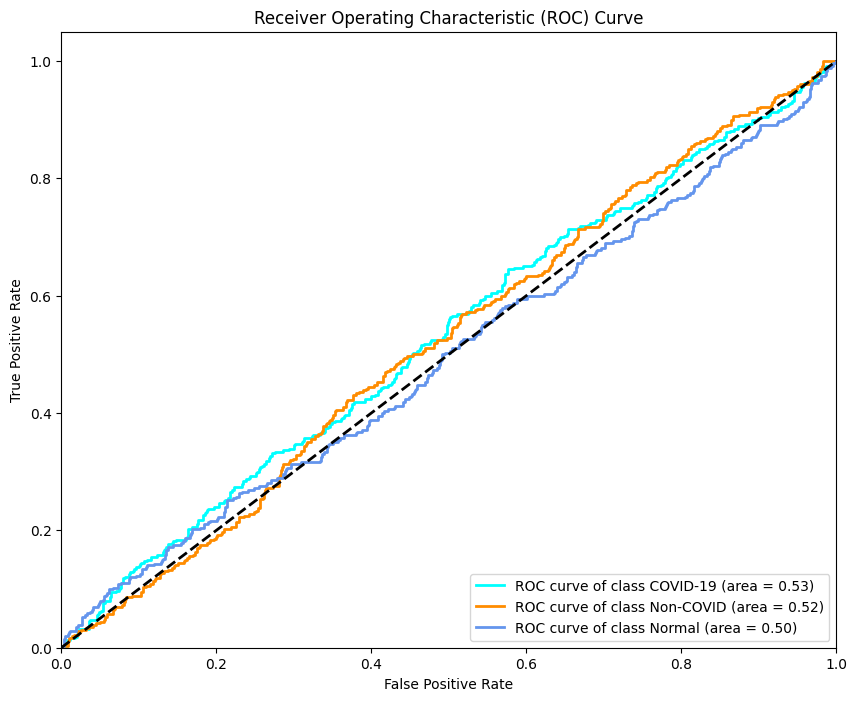

In [20]:
Y_true_bin = label_binarize(Y_true, classes=[0, 1, 2])
n_classes = Y_true_bin.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_true_bin[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(10, 8))
colors = ['aqua', 'darkorange', 'cornflowerblue']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(cm_labels[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


In [21]:
# Print classification report
print(classification_report(Y_true, y_pred_classes, target_names=cm_labels))


              precision    recall  f1-score   support

    COVID-19       0.39      0.34      0.36       380
   Non-COVID       0.35      0.33      0.34       360
      Normal       0.31      0.37      0.34       342

    accuracy                           0.34      1082
   macro avg       0.35      0.34      0.34      1082
weighted avg       0.35      0.34      0.34      1082



In [22]:
for input_img, label in test_generator:
    break

In [23]:
input_img.shape

(32, 256, 256, 1)

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


W0000 00:00:1718155234.104655      87 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━

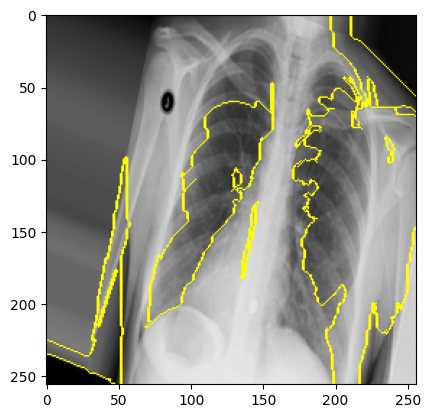

In [24]:
import lime
from lime import lime_image
from skimage.segmentation import mark_boundaries, felzenszwalb

# Initialize the LIME Image Explainer
explainer = lime_image.LimeImageExplainer()

# Define a function to preprocess the input for prediction
def predict_fn(images):
    images = np.array(images)
    return model.predict(images)

# Choose an image to explain
i = 0  # for example, the first image in your test set
image = input_img[i]

# Explain the image prediction using the felzenszwalb segmentation algorithm
explanation = explainer.explain_instance(image, predict_fn, top_labels=3, hide_color=0, num_samples=1000,
                                         segmentation_fn=lambda x: felzenszwalb(x, scale=100, sigma=0.5, min_size=50))

# Get the explanation for a specific class (e.g., class 0)
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=10, hide_rest=False)

# Convert the single-channel grayscale image to a three-channel grayscale image
temp_3ch = np.stack((temp.squeeze(),)*3, axis=-1)

# Display the image with LIME explanation
import matplotlib.pyplot as plt
plt.imshow(mark_boundaries(temp_3ch, mask))
plt.show()

In [25]:
model.save('model_with_weights.h5')